<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Загрузка-данных" data-toc-modified-id="Загрузка-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Загрузка данных</a></span></li><li><span><a href="#Умножение-матриц" data-toc-modified-id="Умножение-матриц-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Умножение матриц</a></span></li><li><span><a href="#Алгоритм-преобразования" data-toc-modified-id="Алгоритм-преобразования-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Алгоритм преобразования</a></span></li><li><span><a href="#Проверка-алгоритма" data-toc-modified-id="Проверка-алгоритма-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Проверка алгоритма</a></span></li></ul></div>

# Защита персональных данных клиентов

Нам нужно защитить данные клиентов страховой компании «Хоть потоп».  
Разработаем такой метод преобразования данных, чтобы по ним было сложно восстановить персональную информацию.

Нужно защитить данные, чтобы при преобразовании качество моделей машинного обучения не ухудшилось. Подбирать наилучшую модель не требуется.

## Загрузка данных

In [1]:
# библиотеки работы с данными
import pandas as pd
import numpy as np

# откючаем предупреждения
import warnings
warnings.filterwarnings('ignore')

# разделение на выборки
from sklearn.model_selection import train_test_split 

# графики
import matplotlib.pyplot as plt 

# модель линейной регрессии
from sklearn.linear_model import LinearRegression

# стандартизация признаков
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# метрики
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# установка настроек для отображения всех колонок при печати
pd.set_option('display.max_columns', None)

from random import randint

In [2]:
df = pd.read_csv('/datasets/insurance.csv')

df.head()

,Пол,Возраст,Зарплата,Члены семьи,Страховые выплаты
0,1,41.0,49600.0,1,0
1,0,46.0,38000.0,1,1
2,0,29.0,21000.0,0,0
3,0,21.0,41700.0,2,0
4,1,28.0,26100.0,0,0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 5 columns):
Пол                  5000 non-null int64
Возраст              5000 non-null float64
Зарплата             5000 non-null float64
Члены семьи          5000 non-null int64
Страховые выплаты    5000 non-null int64
dtypes: float64(2), int64(3)
memory usage: 195.4 KB


In [4]:
df.describe()

,Пол,Возраст,Зарплата,Члены семьи,Страховые выплаты
count,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000
mean,0.499000,30.952800,39916.360000,1.194200,0.148000
std,0.500049,8.440807,9900.083569,1.091387,0.463183
min,0.000000,18.000000,5300.000000,0.000000,0.000000
25%,0.000000,24.000000,33300.000000,0.000000,0.000000
50%,0.000000,30.000000,40200.000000,1.000000,0.000000
75%,1.000000,37.000000,46600.000000,2.000000,0.000000
max,1.000000,65.000000,79000.000000,6.000000,5.000000


In [5]:
df['Пол'].value_counts()

0    2505
1    2495
Name: Пол, dtype: int64

In [6]:
df['Страховые выплаты'].value_counts()

0    4436
1     423
2     115
3      18
4       7
5       1
Name: Страховые выплаты, dtype: int64

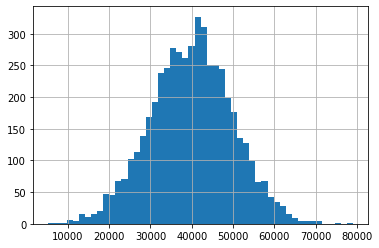

In [7]:
df['Зарплата'].sort_values().hist(bins=50)
plt.show()

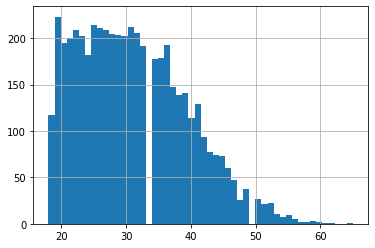

In [8]:
df['Возраст'].sort_values().hist(bins=50)
plt.show()

In [9]:
df.duplicated().sum()

153

**Вывод**  
В таблице нам представлена адекватная информация о клиентах страховой компании: 
- данные в столбцах не имеют пропусков и отрицательных значений
- в столбце "Пол" представлено практически равное количество мужчин и женщин, что может оказаться достаточно полезно для будущих исследований
- данные в столбце с зарплатой имеют нормальное распределение: по гистограмме можно проследить, что чаще всего встречается среднее значение зарплаты в 40 тыс и близкие к нему, а крайние значения встречаются довольно редко
- в датасете собрана информация о людях от 18 до 65 лет, при этом преимущественно возраста в диапазоне от 20 до 40 лет, что вполне может соответствовать реальности
- в основном люди не получали страховые выплаты (из 5 тыс 4436 нулей по столбцу выплат), однако те кто обращался за выплатой разделились не поровну: в основном клиенты получали 1 выплату, реже 2, и совсем редко более 3-4 выплаты, 5 выплат получил лишь 1 клиент
- таблица содержит 153 дубликата, но мы ничего не будем с ними делать, т.к. у клиентов здесь не даны уникальные идентификаторы, а предоставленные данные могут совпадать у разных людей, что вполне соответствует действительности

## Умножение матриц

Обозначения:

- $X$ — матрица признаков (нулевой столбец состоит из единиц)

- $y$ — вектор целевого признака

- $P$ — матрица, на которую умножаются признаки

- $w$ — вектор весов линейной регрессии (нулевой элемент равен сдвигу)

Предсказания:

$$
a = Xw
$$

Задача обучения:

$$
w = \arg\min_w MSE(Xw, y)
$$

Формула обучения:

$$
w = (X^T X)^{-1} X^T y
$$

**Ответ:**  

Качество линейной регрессии не поменяется при умножении признаков на обратимую матрицу
___________

**Обоснование:**

1. Запишем формулу предсказания в матричном виде:  

$$
a = X w = X (X^T X)^{-1} X^T y
$$

2. Пусть матрица V - любая обратимая матрица, а X' - преобразованная матрица признаков.   
Подставим V в формулу задачи обучения, умножив на матрицу признаков X: 

$$
X^{,} = X V
$$ 

$$
w^{,} = ((XV)^T XV)^{-1} (XV)^T y
$$

3. C помощью свойства обратимой матрицы:

$$
(AB)^{-1} = B^{-1} A^{-1}
$$

раскроем скобки:

$$
w^{,} = (XV)^{-1} ((XV)^T)^{-1} (XV)^T y
$$

4. С помощью свойства транспонирования матриц:

$$
(AB)^T = В^T A^T
$$

произведем следующее преобразование формулы, еще раз раскрыв скобки:

$$
w^{,} = V^{-1} X^{-1} (V^T X^T)^{-1} V^T X^T y
$$

$$
w^{,} = V^{-1} X^{-1} (X^T)^{-1} (V^T)^{-1} V^T X^T y
$$

5. Далее используем тождество:

$$
AA^{-1} = A^{-1}A = A A^{-1} = E
$$
*где: $E$ — единичная  матрица*

чтобы еще раз преобразовать нашу формулу:

$$
w^{,} = V^{-1} X^{-1} (X^T)^{-1} E X^T y
$$

$$
w^{,} = V^{-1} (X^T X)^{-1} X^T y
$$

6. Вспомним исходную формулу задачи обучения:

$$
w = (X^T X)^{-1} X^T y
$$

подставим w в нашу формулу по смыслу и получим наглядное соотношение весов в исходной задаче и в преобразованной:

$$
w^{,} = V^{-1} w
$$

7. При этом, если подставим преобразованную матрицу признаков X1 в формулу задачи предсказания:

$$
a^{,} = X^{,} w = XV V^{-1} w = X E w
$$

то получим равенство

$$
a^{,} = X w
$$

$$
a^{,} = a
$$

которое доказывает нам, что при умножении матрицы признаков на обратимую матрицу качество линейной регресии не меняется

## Алгоритм преобразования

**Алгоритм**

- Определим признаки (фичи) и целевой признак (таргет)
- Разделим выборку на тренировочную и тестовую
- Проведем кодирование и стандартизацию признаков 
- Обучим модель до преобразования
- Получим метрику R2 на модели до преобразования матрицы признаков
- Создадим случайную матрицу и проверим ее на обратимость
- Получим преобразованную матрицу признаков, умножив обратимую матрицу на исходную матрицу признаков
- Обучим модель на преобразованной матрице признаков
- Получим метрику R2 на модели после преобразования матрицы признаков
- Сравним полученные метрики R2 между собой
- Сформулируем вывод

**Обоснование**

Данный алгоритм был обоснован с помощью аналитического доказательства, разобранного в предыдущем пункте

## Проверка алгоритма

Разделим исходные данные на признаки (фичи) и целевой признак (таргет)

In [10]:
features = df.drop(['Страховые выплаты'], axis = 1)
target = df['Страховые выплаты']

print('Размер исходного датафрейма:', df.shape,
      '\nРазмер features:', features.shape,
      '\nРазмер target:', target.shape)

Размер исходного датафрейма: (5000, 5) 
Размер features: (5000, 4) 
Размер target: (5000,)


Объявим 4 переменные и запишем в них признаки и таргет обучающей выборки и тестовой выборки (для теста определим размер = 25%)

In [11]:
features_train, features_test, target_train, target_test = train_test_split(
    features, target, test_size=0.25, random_state=42)

print('Размер train:', features_train.shape, target_train.shape,
      '\nРазмер test:', features_test.shape, target_test.shape)

Размер train: (3750, 4) (3750,) 
Размер test: (1250, 4) (1250,)


In [12]:
features_train.head()

,Пол,Возраст,Зарплата,Члены семьи
4884,0,34.0,40200.0,0
3163,0,23.0,33300.0,1
490,0,34.0,43600.0,0
862,1,36.0,34600.0,1
1740,0,36.0,41000.0,1


Мы можем заметить, что у признаков разный разброс, поэтому, чтобы получить адекватные предсказания на них, необходимо их отмасштабировать.  
Тест мы трогать не имеем права, поэтому будем мучать признаки только в тренировочном датасете.

In [13]:
# numeric = ['Возраст', 'Зарплата']

# scaler = MinMaxScaler()
# scaler.fit(features_train[numeric])
# features_train[numeric] = scaler.transform(features_train[numeric])
# features_train.head()

Обучим модель линейной регрессии на исходной матрице признаков,  
получим предсказания  
и оценим их качество метриками R2 и MSE

In [14]:
model_before =  LinearRegression()
model_before.fit(features_train, target_train)
prediction_before = model_before.predict(features_test)

r2_before = r2_score(target_test, prediction_before).round(5)
mse_before = mean_squared_error(target_test, prediction_before).round(5)

print('R2 до преобразования:', r2_before,
     '\nMSE до преобразования:', mse_before)

R2 до преобразования: 0.42548 
MSE до преобразования: 0.13863


Создадим рандомную матрицу 4 на 4 (по количеству фичей в таблице features):  
для этого напишем функцию которая создает рандомную матрицу с входными размерами i на j,  
но возращает ее только убедившись в ее обратимости:

In [15]:
def create_matrix(i,j):
    
    matrix = np.random.normal(0, 1, (i,j))
    
    try:
        inverse = np.linalg.inv(matrix)
        
    except np.linalg.LinAlgError:
        pass
    
    else:
        return matrix 
    
A = create_matrix(4,4)
A

array([[-0.14525214,  0.33060097, -0.17437253,  0.72376155],
       [-1.46563488, -0.92975052,  0.98178157,  0.33965223],
       [ 0.52706029,  1.69514806,  0.07268683, -0.0196294 ],
       [ 1.52030625,  1.53467024,  0.30064313,  1.16390097]])

Сформируем новую матрицу признаков путём умножения исходной матрицы признаков на рандомную обратимую матрицу, созданную нами на предыдущем шаге

In [16]:
features_after = features @ A

features_after.shape

(5000, 4)

In [17]:
features_train, features_test, target_train, target_test = train_test_split(
    features_after, target, test_size=0.25, random_state=42)

print('Размер train:', features_train.shape, target_train.shape,
      '\nРазмер test:', features_test.shape, target_test.shape)

Размер train: (3750, 4) (3750,) 
Размер test: (1250, 4) (1250,)


Обучим модель линейной регрессии на трансформированной матрице признаков,  
получим предсказания  
и оценим их качество метрикой R2

In [18]:
model_after =  LinearRegression()
model_after.fit(features_train, target_train)
prediction_after = model_after.predict(features_test)

r2_after = r2_score(target_test, prediction_after).round(5)
mse_after = mean_squared_error(target_test, prediction_after).round(5)

print('R2 после преобразования:', r2_after,
     '\nMSE после преобразования:', mse_after)

R2 после преобразования: 0.42548 
MSE после преобразования: 0.13863


Убедимся что показатели метрик R2 и MSE равны

In [19]:
r2_before == r2_after 

True

In [20]:
mse_before == mse_after 

True

Таким образом, сделаем **вывод** о том, что гипотеза неизменности качества линейной регрессии при умножении признаков на любую обратимую матрицу оказалась верна.